# Data Preparation
### Training a Neural Network to identify the best M3 Combo
By Zach Shelton
5/13/21


In [1]:
#NanoAOD HackSchema
#Solution from Danny Noonan

In [10]:
from __future__ import print_function, division
import uproot
import numpy as np
#Make sure to install both old awkward0 and new awkward1(referred to now as awkward)
import awkward1 as ak
import awkward0 as ak0
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
import coffea
from uproot3_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import coffea.hist as hist
import matplotlib.pyplot as plt
import awkward
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
import coffea.processor as processor
from pprint import pprint
file=uproot.open(files)
from pprint import pprint

## Note: It seems the Jet columns are sorted from greatest p_t to smallest p_t
Feel free to test, but it seems to be my observation, choosing the 1st, 2nd or 3rd jet via index should remove the issue of it being a coffea sorting artifact or procedure

In [11]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events =NanoEventsFactory.from_root(files,schemaclass=HackSchema,entry_stop=500).events()

In [12]:
#Condensing_all Lepton_cuts
jets=events.Jet
jetSel = (jets.pt>30) & (abs(jets.eta)<2.4)
tightJet = jets[jetSel]
bJet = tightJet[tightJet.btagDeepFlavB > 0.642]
muons = events.Muon
muonSel = (muons.pt>30) & (abs(muons.eta)<2.4)
tightMuon = muons[muonSel]
ele = events.Electron
eleSel = (ele.pt>35)&(abs(ele.eta)<2.4)
tightEle = ele[eleSel]
eventSel = (((ak.num(tightMuon)==1) | (ak.num(tightEle)==1)) &
            (ak.num(tightJet)>= 3) & (ak.num(bJet)>=1)
           )
final = events[eventSel]

In [13]:
#G = Global index of particles - Artifact from Coffea/NanoAOD Tools
print(len(final))

308


In [14]:
genPart = final.GenPart
tops = genPart[abs(genPart.pdgId)==6]
tops = tops[tops.hasFlags('isLastCopy')]
print(tops.pdgId)
tDecay = tops.distinctChildren
tDecay = tDecay[tDecay.hasFlags('isLastCopy')]
print(tDecay.pdgId)
t_Events=tDecay[abs(tDecay.pdgId)==5]
W = tDecay[abs(tDecay.pdgId)==24]
W = W[W.hasFlags('isLastCopy')]
WDecay = W.distinctChildren
WDecay = WDecay[WDecay.hasFlags('isLastCopy')]
print(WDecay.pdgId)
#t_events is the lone bottom, W_events is the -> two jets

[[6, -6], [6, -6], [6, -6], [6, -6], [6, ... -6], [6, -6], [6, -6], [6, -6], [6, -6]]
[[[24, 5], [-24, -5]], [[24, 5], [-24, -5, ... 5], [-24, -5]], [[24, 5], [-24, -5]]]
[[[[2, -1]], [[15, -16]]], [[[4, -3]], ... [[15, -16]]], [[[2, -1]], [[13, -14]]]]


In [15]:
W_Events=ak.flatten(WDecay[ak.all(abs(WDecay.pdgId)<=8,axis=-1)],axis=3)


In [16]:
qqb_events=ak.concatenate([t_Events,W_Events],axis=2)
print(qqb_events[0].pdgId)
qqbmask=((ak.count(qqb_events.pt,axis=2)>2))
print(qqbmask)
hadronicevents=qqb_events[qqbmask]

[[5, 2, -1], [-5]]
[[True, False], [True, False], [False, True, ... True], [True, False], [True, False]]


In [17]:
from coffea.nanoevents.methods import vector
import uproot_methods
ak.behavior.update(vector.behavior)
#jet_kinematics=uproot_methods.TLorentzVectorArray.from_ptetaphim(final.Jet.pt,final.Jet.eta,final.Jet.phi,final.Jet.mass)
jet_kinematics=ak.zip({"pt":final.Jet.pt,"eta":final.Jet.eta,"phi":final.Jet.phi,"mass":final.Jet.mass},with_name="PtEtaPhiMLorentzVector")

In [22]:
def nearest(self,jet_array):
    ak.agrmin(self.p4.delta_r())

In [23]:
#This uses Delta_r as the GenPart/Jet does not inherit nearest(), which is annoying. So the first loop run delta_r for each jet to every GenPart.
f_delta=ak.ArrayBuilder()
loc=ak.ArrayBuilder()
j_data=ak.zip({"p4":jet_kinematics,"btag":final.Jet.btagDeepFlavB,"area":final.Jet.area,"event":final.event})
j_data
for x in range(0,len(jets)):
    l=ak.ArrayBuilder()
    for r in range(0,len(jets.p4[x])):
        if(len(hadronicevents[x])>0):
            l.append(jets.p4[x][r].delta_r(hadronicevents[x])[0])
        else:
            l.append([None,None,None])
        #print("jet %s"%r)
    f_delta.append(l)
jetcombos=ak.ArrayBuilder()
for x in range(0,len(jets)):
    #print(pd.loc[x])
    jetcombos.append(tuple(ak.sort((pd.loc[x,:,0]['values'].argmin(),pd.loc[x,:,1]['values'].argmin(),pd.loc[x,:,2]['values'].argmin()))))
    #print(j)
print("jetcombos made")
print(len(args))
args=ak.argcombinations(j_data,3,highlevel=True)
combs=ak.combinations(j_data,3,highlevel=True) 
t=((args['0']==jetcombos['0'])&(args['1']==jetcombos['1'])&(args['2']==jetcombos['2']))
validation=ak.flatten(t)
recofinal=combs['0']+combs['1']+combs['2']
test_reco=ak.flatten(recofinal)
test_jets=ak.flatten(combs,axis=-1)


AttributeError: no field named 'p4'

(https://github.com/scikit-hep/awkward-1.0/blob/0.4.5/src/awkward1/highlevel.py#L1084)

In [24]:
from matplotlib import pyplot as plt

### Observations
1. There is a clear separation of mass, indicating that the process above is correctly selecting values (with outliers)

In [25]:
good=test_reco[validation]
bad=test_reco[np.invert(validation)]
from scipy.stats import norm
good_fitmu,gfstd=norm.fit(np.array(good.p4.mass))
bad_fitmu,bfstd=norm.fit(bad.p4.mass)
xmin, xmax = 0,800
x = np.linspace(xmin, xmax, 800)
p1 = norm.pdf(x, good_fitmu, gfstd)
plt.plot(x, p1, 'k', linewidth=2)
p2 = norm.pdf(x, bad_fitmu, bfstd)
plt.plot(x, p2, 'k', linewidth=2)
print(good_fitmu,gfstd)
plt.hist(bad['p4'].mass[0:1000],bins=50,alpha=.5,density=True)
plt.hist(good['p4'].mass,bins=50,alpha=.5,density=True)
plt.legend(["False","True"])
plt.title("Histogram of Mass(Density)")
plt.show()

NameError: name 'test_reco' is not defined

In [26]:
outliers=good[good['p4'].mass>250]
print(len(outliers.p4.pt))


NameError: name 'good' is not defined

### Observations:
1. Not many differences in the Kinematics of true and false data(at visual observation)

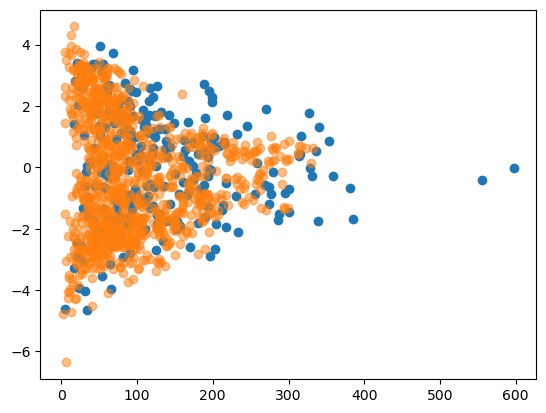

In [199]:
plt.scatter(good['p4'].pt,good['p4'].eta)
plt.scatter(bad['p4'].pt[0:1000],bad['p4'][0:1000].eta,alpha=.5)
plt.show()

In [247]:
good['p4'][0].delta_r(good['p4'][1])
good['p4'].pt[0]
combs['0']['p4']

<PtEtaPhiMLorentzVectorArray [[{pt: 123, ... mass: 6.23}]] type='308 * var * PtE...'>

In [22]:
t_array=ak.ArrayBuilder()
for val in test_jets:
    t_array.append([val['0']['p4'].delta_r(val['1']['p4']),
                    val['0']['p4'].delta_r(val['2']['p4']),
                    val['1']['p4'].delta_r(val['2']['p4'])])
print(len(validation))
good_deltar=t_array[validation]
bad_deltar=t_array[np.invert(validation)]

23446


In [216]:
final.GenPart.fields

['childrenIdxG',
 'distinctChildrenIdxG',
 'distinctParentIdxG',
 'eta',
 'genPartIdxMother',
 'genPartIdxMotherG',
 'mass',
 'pdgId',
 'phi',
 'pt',
 'status',
 'statusFlags']

In [235]:
print(len(ak.any(abs(final.GenPart.distinctChildren.pdgId)==6,axis=-1)))
len(final)

308


308

In [231]:
#test_jets[1]['1'].event
postoverlay_events=(test_jets[validation])
print(len(postoverlay_events))
print(len(pevents))
genevents=final[ak.any(abs(final.GenPart.distinctChildren.pdgId)==6,axis=-1)]
print(len(genevents))
#genevents==pevents

275
275


ValueError: in ListArray64 attempting to get 0, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/0.4.5/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L46)

In [19]:
plt.hist(ak.min(bad_deltar[0:500],axis=1),bins=30)
plt.hist(ak.min(good_deltar,axis=1),bins=30)
plt.show()

NameError: name 'bad_deltar' is not defined

______________________________________________________________________________
# Running Notes and questions
- Losing Data because of arbitrary 8 jet cut?

## Notes for Zach to keep up

Wrap into Coffea Executor!!!!!!!!!!!!

Seperate values, weights and triggers(X)
read these into tensors for Keras(X)
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
- Combine old processes together
Should I use Keras or PyTorch

## Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

AOD DATA GUIDE: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideAodDataTable